In [5]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re

In [7]:
#To read csv file and create dataframe
tweets = pd.read_csv('processed_tweet_data.csv')
tweets.head()

created_at  \
0  Fri Jun 18 17:55:49 +0000 2021   
1  Fri Jun 18 17:55:59 +0000 2021   
2  Fri Jun 18 17:56:07 +0000 2021   
3  Fri Jun 18 17:56:10 +0000 2021   
4  Fri Jun 18 17:56:20 +0000 2021   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="https://mobile.twitter.com" rel="nofo...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="https://mobile.twitter.com" rel="nofo...   
4  <a href="http://twitter.com/download/android" ...   

                                       original_text  polarity  subjectivity  \
0  🚨Africa is "in the midst of a full-blown third...  0.166667      0.188889   
1  Dr Moeti is head of WHO in Africa, and one of ...  0.133333      0.455556   
2  Thank you @research2note for creating this ama...  0.316667      0.483333   
3  Former Pfizer VP and Virologist, Dr. Michael Y...  0.086111      0.197222   
4  I think it’s important that we don’t sell COVA...  0.280000      0.620000   

  lang  favorite_count  retweet_count original_author  followers_count  \
0   en             548          612.0     ketuesriche              551   
1   en             195           92.0        Grid1949               66   
2   en               2            1.0   LeeTomlinson8             1195   
3   en            1580          899.0         RIPNY08             2666   
4   en              72           20.0          pash22            28250   

   friends_count  possibly_sensitive  \
0            351                 NaN   
1             92                 NaN   
2           1176                 NaN   
3           2704                 NaN   
4          30819                 NaN   

                                            hashtags  \
0                                                 []   
1                                                 []   
2  [{'text': 'red4research', 'indices': [103, 116]}]   
3                                                 []   
4                                                 []   

                                       user_mentions                place  
0  [{'screen_name': 'TelGlobalHealth', 'name': 'T...                 Mass  
1  [{'screen_name': 'globalhlthtwit', 'name': 'An...  Edinburgh, Scotland  
2  [{'screen_name': 'NHSRDForum', 'name': 'NHS R&...                  NaN  
3  [{'screen_name': 'HighWireTalk', 'name': 'The ...                  NaN  
4  [{'screen_name': 'PeterHotez', 'name': 'Prof P...       United Kingdom

In [8]:
#To get information abou the data
tweets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   source              6532 non-null   object 
 2   original_text       6532 non-null   object 
 3   polarity            6532 non-null   float64
 4   subjectivity        6532 non-null   float64
 5   lang                6532 non-null   object 
 6   favorite_count      6532 non-null   int64  
 7   retweet_count       4785 non-null   float64
 8   original_author     6532 non-null   object 
 9   followers_count     6532 non-null   int64  
 10  friends_count       6532 non-null   int64  
 11  possibly_sensitive  0 non-null      float64
 12  hashtags            6532 non-null   object 
 13  user_mentions       6532 non-null   object 
 14  place               4088 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 765.6+

In [9]:
print("The number of missing value(s): {}".format(tweets.isnull().sum().sum()))
print("Columons having columns value:{}".format(tweets.columns[tweets.isnull().any()]))

The number of missing value(s): 10723
Columons having columns value:Index(['retweet_count', 'possibly_sensitive', 'place'], dtype='object')


In [10]:
tweets_df = pd.DataFrame(columns=['original_text','clean_text','lang'])

tweets_df['original_text'] =  tweets['original_text'].to_list()
tweets_df['clean_text'] =  tweets['clean_text'].to_list()
tweets_df['lang'] = tweets['lang'].to_list()

KeyError: 'clean_text'

In [11]:
# drop row having Null value
tweets_df.dropna()
tweets_df

original_text clean_text lang
0     🚨Africa is "in the midst of a full-blown third...        NaN  NaN
1     Dr Moeti is head of WHO in Africa, and one of ...        NaN  NaN
2     Thank you @research2note for creating this ama...        NaN  NaN
3     Former Pfizer VP and Virologist, Dr. Michael Y...        NaN  NaN
4     I think it’s important that we don’t sell COVA...        NaN  NaN
...                                                 ...        ...  ...
6527  RT @Givenkazeni: Zweli please just release the...        NaN  NaN
6528  Former Pfizer VP and Virologist, Dr. Michael Y...        NaN  NaN
6529  @Jenfeds73 @DcrInYYC Respectfully, veterinaria...        NaN  NaN
6530  "Africa needs millions more doses here &amp; n...        NaN  NaN
6531  RT @shawajason: Liars. You tried to load off y...        NaN  NaN

[6532 rows x 3 columns]

In [12]:
re.findall?

In [13]:
#Method to find hashtags from tweets
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [14]:
# update Hashtage columon with hashtages extracted from Orignal_text columon
tweets_df['hashtags'] = tweets_df.original_text.apply(find_hashtags)
print(tweets_df['hashtags'])

0                        []
1                        []
2           [#red4research]
3                [#Covid19]
4                        []
               ...         
6527                     []
6528             [#Covid19]
6529                     []
6530    [#COVID19, #Africa]
6531                     []
Name: hashtags, Length: 6532, dtype: object


In [15]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = tweets_df.loc[
                       tweets_df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [16]:
 #create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [17]:
flattened_hashtags_df

hashtag
0         #red4research
1              #Covid19
2          #WeCanDoThis
3              #COVID19
4              #Covid19
...                 ...
7047   #OriginOfCOVID19
7048  #VaccinationDrive
7049           #Covid19
7050           #COVID19
7051            #Africa

[7052 rows x 1 columns]

In [18]:
#add flatten_hashtags to tweet_df
tweets_df["flattened_hashtags"]= flattened_hashtags_df

In [19]:
tweets_df

original_text clean_text lang  \
0     🚨Africa is "in the midst of a full-blown third...        NaN  NaN   
1     Dr Moeti is head of WHO in Africa, and one of ...        NaN  NaN   
2     Thank you @research2note for creating this ama...        NaN  NaN   
3     Former Pfizer VP and Virologist, Dr. Michael Y...        NaN  NaN   
4     I think it’s important that we don’t sell COVA...        NaN  NaN   
...                                                 ...        ...  ...   
6527  RT @Givenkazeni: Zweli please just release the...        NaN  NaN   
6528  Former Pfizer VP and Virologist, Dr. Michael Y...        NaN  NaN   
6529  @Jenfeds73 @DcrInYYC Respectfully, veterinaria...        NaN  NaN   
6530  "Africa needs millions more doses here &amp; n...        NaN  NaN   
6531  RT @shawajason: Liars. You tried to load off y...        NaN  NaN   

                 hashtags       flattened_hashtags  
0                      []            #red4research  
1                      []                 #Covid19  
2         [#red4research]             #WeCanDoThis  
3              [#Covid19]                 #COVID19  
4                      []                 #Covid19  
...                   ...                      ...  
6527                   []   #UnrestrictedBioweapon  
6528           [#Covid19]                 #COVID19  
6529                   []  #UnrestrictedBiowarfare  
6530  [#COVID19, #Africa]                 #COVID19  
6531                   []                  #VOWnow  

[6532 rows x 5 columns]

<AxesSubplot:>

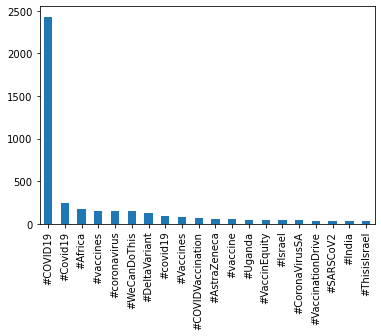

In [20]:
# To plot Top 20 Hashtags
tweets_df['flattened_hashtags'].value_counts()[:20].plot(kind='bar')

In [21]:
#ploting Tweets by language 
tweets = pd.DataFrame(columns=['text','lang'])

tweets['text'] =  tweets_df['clean_text'].to_list()
tweets['lang'] = tweets_df['lang'].to_list()

tweets_by_lang = tweets['lang'].value_counts()

IndexError: index 0 is out of bounds for axis 0 with size 0

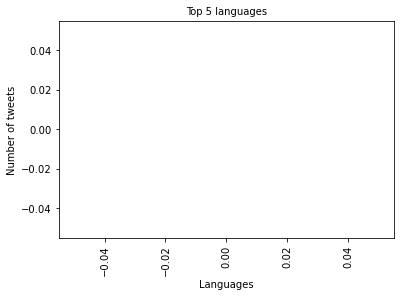

In [22]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=10)
ax.set_ylabel('Number of tweets' , fontsize=10)
ax.set_title('Top 5 languages', fontsize=10)
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='orange')

In [23]:
#from Our Language analysis we can see there are differnt languages we can select only tweets with english 
English_tweets = tweets_df.loc[tweets_df['lang'] =="en"]

In [24]:
English_tweets

Empty DataFrame
Columns: [original_text, clean_text, lang, hashtags, flattened_hashtags]
Index: []

In [25]:
#text Preprocessing
English_tweets['clean_text']=English_tweets['clean_text'].astype(str)
English_tweets['clean_text'] = English_tweets['clean_text'].apply(lambda x: x.lower())
English_tweets['clean_text']= English_tweets['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))


In [26]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(English_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

<Figure size 1440x720 with 0 Axes>

In [27]:
#Converting tweets to list of words For feature engineering
sentence_list = [tweet for tweet in English_tweets['clean_text']]
word_list = [sent.split() for sent in sentence_list]

word_list[:2]


[]

In [28]:
#Create dictionary which contains Id and word 
word_to_id = corpora.Dictionary(word_list)
for k, v in word_to_id.items():
    print(k,"........",v)

In [29]:
corpus_1[:2] = [word_to_id.doc2bow(tweet) for tweet in word_list]

NameError: name 'corpus_1' is not defined